In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [18]:
# Step 2: Define the tickers and fetch historical data
tickers = ['TCS.NS', 'ITC.NS', 'SHRIRAMFIN.NS', 'WIT', 'RELIANCE.NS']
start_date = '2023-01-01'
end_date = '2024-01-01'

In [20]:
# Fetch historical price data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [22]:
# Step 3: Calculate daily returns
returns = data.pct_change().dropna()

C:\Users\HP\AppData\Local\Temp\ipykernel_11956\2912040705.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


In [24]:
# Step 4: Define portfolio weights
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Equal weights for simplicity

In [26]:
# Step 5: Calculate portfolio returns
portfolio_returns = returns.dot(weights)

In [28]:
# Step 6: Calculate Historical VaR
def historical_var_portfolio(returns, confidence_level=0.95):
    """Calculate historical VaR for a portfolio."""
    return np.percentile(returns, (1 - confidence_level) * 100)

In [30]:
# Calculate VaR for the portfolio
var_portfolio = historical_var_portfolio(portfolio_returns)
print(f"Portfolio VaR (95%): {-var_portfolio:.4f}")

Portfolio VaR (95%): 0.0104


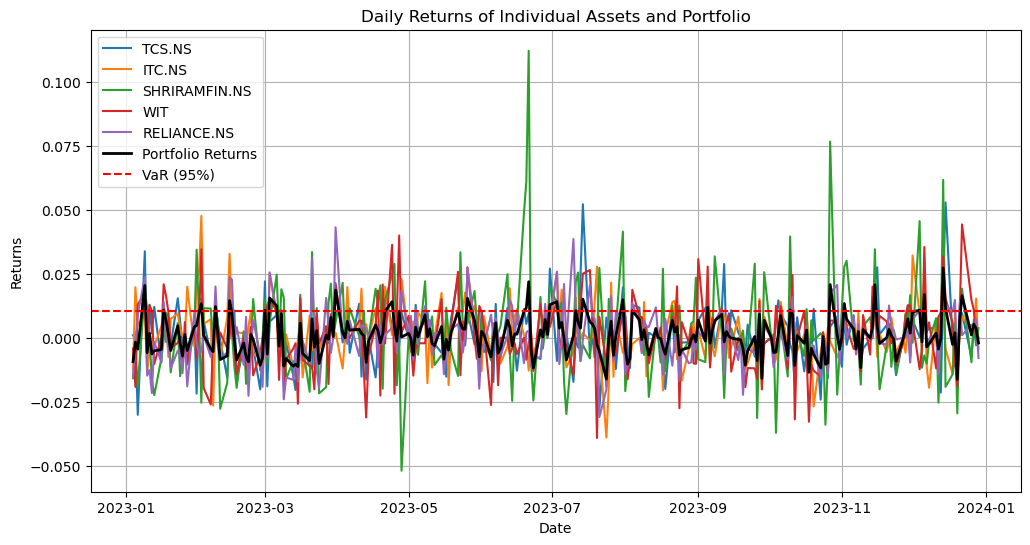

In [40]:
# Step 7: Plotting the returns
plt.figure(figsize=(12, 6))
# Plot individual asset returns
for ticker in tickers:
    plt.plot(returns[ticker], label=ticker)
# Plot portfolio returns
plt.plot(portfolio_returns, label='Portfolio Returns', color='black', linewidth=2)

plt.title('Daily Returns of Individual Assets and Portfolio')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.axhline(y=-var_portfolio, color='red', linestyle='--', label='VaR (95%)')
plt.legend()
plt.grid()
plt.show()

In [42]:
# Step 8: Monte Carlo Simulation for Portfolio VaR
def monte_carlo_var_portfolio(returns, weights, num_simulations=10000, confidence_level=0.95):
    """Calculate VaR using Monte Carlo simulation."""
    mean_returns = np.mean(returns, axis=0)
    cov_matrix = np.cov(returns, rowvar=False)

    # Generate random returns based on normal distribution
    simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)

    # Calculate portfolio returns for the simulated data
    simulated_portfolio_returns = simulated_returns.dot(weights)

    # Calculate VaR from the simulated portfolio returns
    return np.percentile(simulated_portfolio_returns, (1 - confidence_level) * 100)


In [44]:
# Calculate Monte Carlo VaR for the portfolio
var_monte_carlo = monte_carlo_var_portfolio(returns, weights)
print(f"Monte Carlo Portfolio VaR (95%): {-var_monte_carlo:.4f}")

Monte Carlo Portfolio VaR (95%): 0.0113


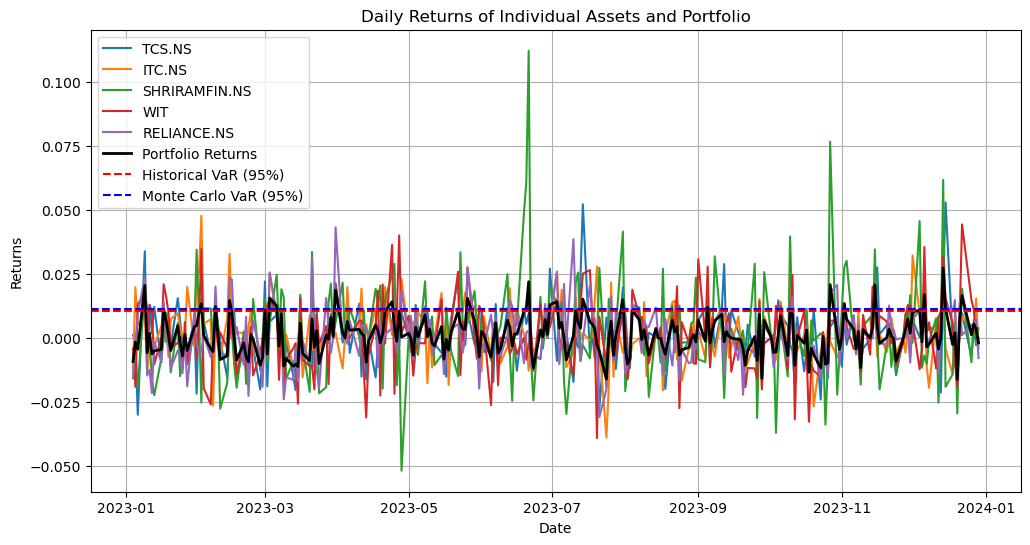

In [48]:
# Step 9: Plotting the returns
plt.figure(figsize=(12, 6))

# Plot individual asset returns
for ticker in tickers:
    plt.plot(returns[ticker], label=ticker)
    
# Plot portfolio returns
plt.plot(portfolio_returns, label='Portfolio Returns', color='black', linewidth=2)

# Plot VaR lines
plt.axhline(y=-var_portfolio, color='red', linestyle='--', label='Historical VaR (95%)')
plt.axhline(y=-var_monte_carlo, color='blue', linestyle='--', label='Monte Carlo VaR (95%)')

plt.title('Daily Returns of Individual Assets and Portfolio')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()


In [60]:
# Step 10: Variance-Covariance Method for Portfolio VaR
from scipy.stats import norm
def variance_covariance_var(weights, mean_returns, cov_matrix, confidence_level=0.95):
    """Calculate VaR using the Variance-Covariance method."""
    portfolio_mean = np.sum(mean_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Calculate the z-score for the confidence level
    z_score = -1 * norm.ppf(1 - confidence_level)
    
    # Calculate VaR
    var = portfolio_mean + portfolio_std_dev * z_score
    return var


In [54]:
# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [62]:
# Calculate Variance-Covariance VaR for the portfolio
var_variance_covariance = variance_covariance_var(weights, mean_returns, cov_matrix)
print(f"Variance-Covariance Portfolio VaR (95%): {-var_variance_covariance:.4f}")

Variance-Covariance Portfolio VaR (95%): -0.0134


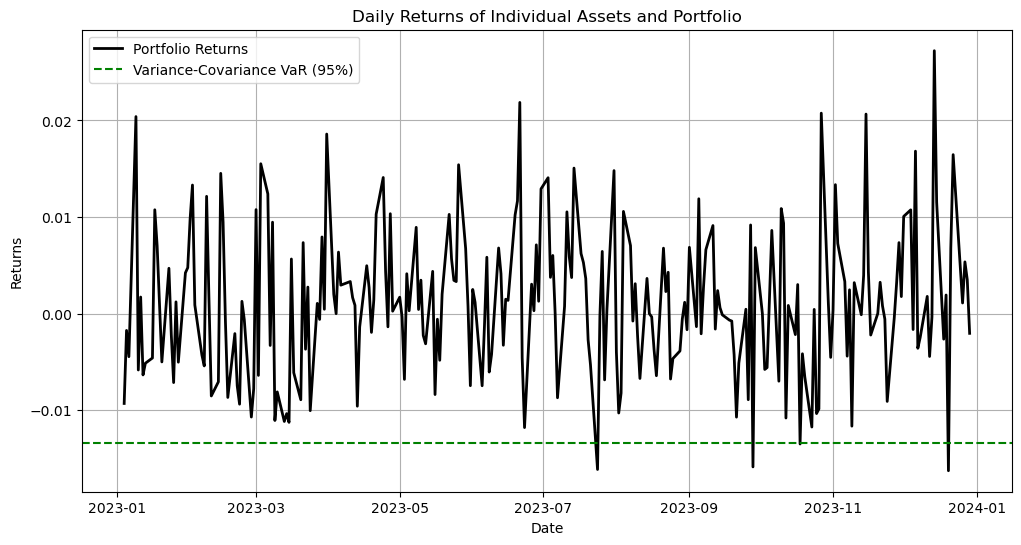

In [74]:
# Step 11: Plotting the returns
plt.figure(figsize=(12, 6))


# Plot portfolio returns
plt.plot(portfolio_returns, label='Portfolio Returns', color='black', linewidth=2)

# Plot VaR lines
plt.axhline(y=-var_variance_covariance, color='green', linestyle='--', label='Variance-Covariance VaR (95%)')

plt.title('Daily Returns of Individual Assets and Portfolio')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

Historical Portfolio VaR (95%): 0.0104
Historical Portfolio Expected Shortfall (95%): 0.0125
Monte Carlo Portfolio VaR (95%): 0.0114
Monte Carlo Portfolio Expected Shortfall (95%): 0.0144
Variance-Covariance Portfolio VaR (95%): -0.0134
Variance-Covariance Portfolio Expected Shortfall (95%): -0.0165


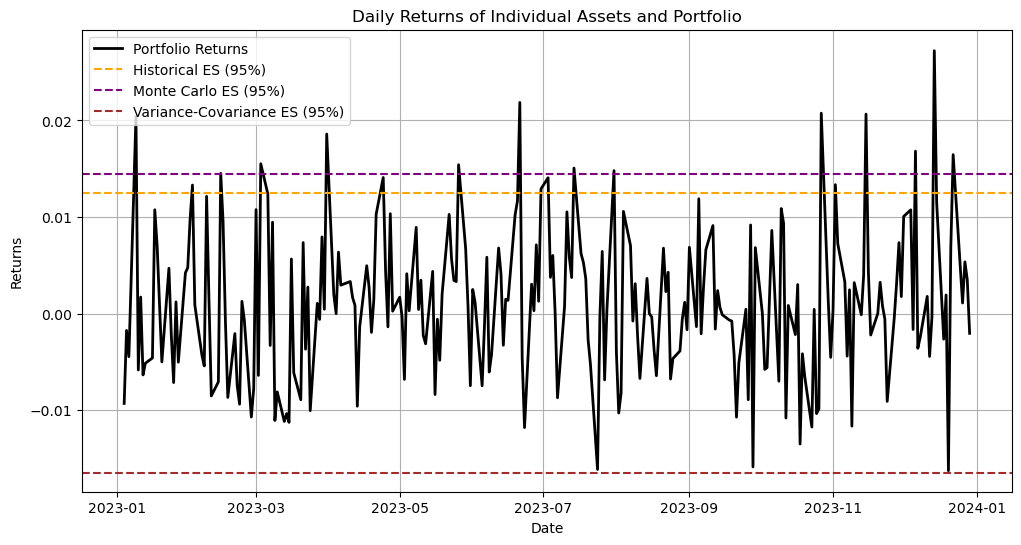

In [72]:
#Expected Shortfall 
# Step 13: Historical VaR and Expected Shortfall
def historical_var_es_portfolio(returns, confidence_level=0.95):
    """Calculate Historical VaR and Expected Shortfall for a portfolio."""
    var = np.percentile(returns, (1 - confidence_level) * 100)
    es = returns[returns <= var].mean()  # ES is the average of losses beyond VaR
    return var, es

# Calculate Historical VaR and ES for the portfolio
var_portfolio, es_portfolio = historical_var_es_portfolio(portfolio_returns)
print(f"Historical Portfolio VaR (95%): {-var_portfolio:.4f}")
print(f"Historical Portfolio Expected Shortfall (95%): {-es_portfolio:.4f}")

# Step 14: Monte Carlo Simulation VaR and Expected Shortfall
def monte_carlo_var_es_portfolio(returns, weights, num_simulations=10000, confidence_level=0.95):
    """Calculate VaR and ES using Monte Carlo simulation."""
    mean_returns = np.mean(returns, axis=0)
    cov_matrix = np.cov(returns, rowvar=False)

    # Generate random returns based on normal distribution
    simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)

    # Calculate portfolio returns for the simulated data
    simulated_portfolio_returns = simulated_returns.dot(weights)

    # Calculate VaR and ES from the simulated portfolio returns
    var = np.percentile(simulated_portfolio_returns, (1 - confidence_level) * 100)
    es = np.mean(simulated_portfolio_returns[simulated_portfolio_returns <= var])
    return var, es

# Calculate Monte Carlo VaR and ES for the portfolio
var_monte_carlo, es_monte_carlo = monte_carlo_var_es_portfolio(returns, weights)
print(f"Monte Carlo Portfolio VaR (95%): {-var_monte_carlo:.4f}")
print(f"Monte Carlo Portfolio Expected Shortfall (95%): {-es_monte_carlo:.4f}")

# Step 15: Variance-Covariance VaR and Expected Shortfall
def variance_covariance_var_es(weights, mean_returns, cov_matrix, confidence_level=0.95):
    """Calculate VaR and ES using the Variance-Covariance method."""
    portfolio_mean = np.sum(mean_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Calculate the z-score for the confidence level
    z_score = -1 * norm.ppf(1 - confidence_level)
    
    # Calculate VaR
    var = portfolio_mean + portfolio_std_dev * z_score
    
    # Calculate Expected Shortfall using ES formula for normal distribution
    es = portfolio_mean + portfolio_std_dev * (norm.pdf(z_score) / (1 - confidence_level))
    
    return var, es

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Calculate Variance-Covariance VaR and ES for the portfolio
var_variance_covariance, es_variance_covariance = variance_covariance_var_es(weights, mean_returns, cov_matrix)
print(f"Variance-Covariance Portfolio VaR (95%): {-var_variance_covariance:.4f}")
print(f"Variance-Covariance Portfolio Expected Shortfall (95%): {-es_variance_covariance:.4f}")

# Step 16: Plotting the returns and VaR/ES
plt.figure(figsize=(12, 6))


# Plot portfolio returns
plt.plot(portfolio_returns, label='Portfolio Returns', color='black', linewidth=2)

# Plot ES lines
plt.axhline(y=-es_portfolio, color='orange', linestyle='--', label='Historical ES (95%)')
plt.axhline(y=-es_monte_carlo, color='purple', linestyle='--', label='Monte Carlo ES (95%)')
plt.axhline(y=-es_variance_covariance, color='brown', linestyle='--', label='Variance-Covariance ES (95%)')

plt.title('Daily Returns of Individual Assets and Portfolio')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()